# Tutorial on NN
- how to interactively select your training set from image
- how to save crops
- how to load crops 
- how to featurize image
- how to train NN

In [19]:
import os
import numpy as np

# Import the cropping widget and example images
from interactivecrop.interactivecrop import main as crop

PATH_TO_SAMPLES = '/global/u1/u/ushizima/xray/esther/code/samples/'

In [20]:
#a = io.imread(PATH_TO_SAMPLES + 'dry_bf.png')

In [21]:
from skimage import io
ic = io.imread_collection(PATH_TO_SAMPLES+'*.png')
sample_images = io.concatenate_images(ic)
image_name_list = ic.files

In [22]:
sample_images.shape

(1, 1024, 1024)

In [348]:
%rm training.csv
df = pd.DataFrame(columns = ['filename', 'cropDim'])
df.to_csv('training.csv', mode='w', header=True)

## Standard Usage with Image Arguments

In [350]:
import csv
# Define the callback to save the image
def callback(image_name, shape):
    df = pd.DataFrame(columns=['file','cropdim'])
    df.loc[0,:]= image_name, shape.size
    df.to_csv('training.csv', mode='a', header=False)

crop(sample_images, image_name_list=image_name_list, callback=callback, continuous_update=False)

GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

In [332]:
%cat training.csv


,filename,cropDim
0,/global/u1/u/ushizima/xray/esther/code/samples/dry_bf.png,"(341, 342, 217, 341)"
0,/global/u1/u/ushizima/xray/esther/code/samples/dry_bf.png,"(326, 605, 239, 402)"


# Compute local features for a single- or multi-channel nd image.
- Intensity, gradient intensity and local structure are computed at different scales using Gaussian blurring.

In [333]:
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from functools import partial
import pandas as pd

In [351]:

full_img = io.imread('/global/u1/u/ushizima/xray/esther/code/samples/dry_bf.png')
img = full_img
training_labels = np.zeros(img.shape, dtype=np.uint8)

df = pd.read_csv('training.csv')
for i,tup in enumerate(df['cropDim']):
    w,h,dw,dh = eval(tup)
    training_labels[h:(h+dh),w:(w+dw)]=i+1

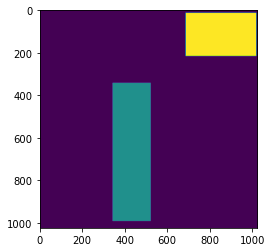

In [352]:
plt.imshow(training_labels)

(1024, 1024)
(341, 342, 217, 341)
(326, 605, 239, 402)


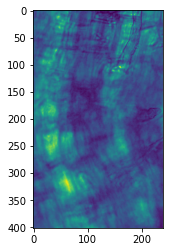

In [344]:
#Double check
print(full_img.shape)
for i,tup in enumerate(df['cropDim']):
    print(eval(tup))
    w,h,dw,dh = eval(tup)
plt.imshow(full_img[h:(h+dh),w:(w+dw)])

In [353]:
# Feature extraction
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(img)


In [362]:
# Classification with MLP using relu activation function, adam solver for weight optimization, alpha = 0.0001, batch_size=200, learning_rate = constant, shuffle samples, validation_fraction=0.1
# other params at https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

clf = MLPClassifier(random_state=1, activation = 'relu', solver = 'adam', alpha = 0.0001, batch_size=200, max_iter=100)
#clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)

clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)


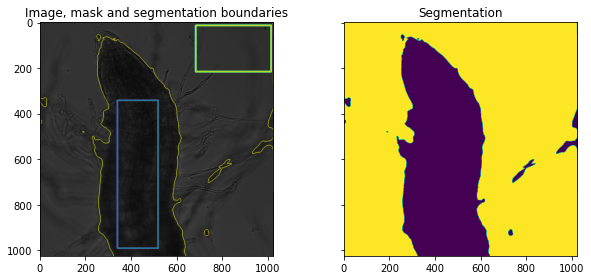

In [363]:
# Visualization of results
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result)
ax[1].set_title('Segmentation')
fig.tight_layout()